In [1]:
import ctyparser
import gspread as gs
import matplotlib
import os
import pandas as pd
import re
from ipyleaflet import Map, basemaps, basemap_to_tiles

In [2]:
if os.environ.get('NETLIFY'):
    credentialkeys = ['type', 'project_id', 'private_key_id', 'private_key', 'client_email',
                     'client_id', 'auth_url', 'token_uri', 'auth_provider_x509_cert_url', 'client_x509_cert_url']
    credentials = {}
    for key in credentialkeys:
        credentials['key'] = os.environ.get(key)
    gc = gs.service_account_from_dict(credentials)
    sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dpciJGykIvwxHWgWrw_KTVi10EisyUZ6cah962oaStI/edit?usp=sharing')
    ws = sh.worksheet('Form responses 1')
else:
    gc = gs.service_account(filename='../workedalloarc-72453018052d.json')
    sh = gc.open_by_url('https://docs.google.com/spreadsheets/d/1dpciJGykIvwxHWgWrw_KTVi10EisyUZ6cah962oaStI/edit?usp=sharing')
    ws = sh.worksheet('Form responses 1')

In [3]:
df = pd.DataFrame(ws.get_all_records())
df.head(10)

,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details
0,26/04/2022 20:34:04,27/04/2022 12:23:00,M0SMU,M7SMU,144 MHz (2m),FM,IO81oj,IO81ql,EU-005,Not innovative at all,test
1,26/04/2022 20:34:35,19/04/2022 09:00:00,M0SMU,2E0UMS,7 MHz (40m),SSB,,,,,
2,26/04/2022 20:37:12,24/04/2021 11:00:00,2e0ggj,m0nvk,7 MHz (40m),SSB,io95fb,m0nvk home qth,,Ran one or two full courses :-),Am a good egg !
3,26/04/2022 20:39:58,20/03/2022 19:31:00,mojqq,m0lte,7 MHz (40m),Olivia,io95ec,nk,,,
4,26/04/2022 20:41:07,26/04/2022 15:30:00,m0jqq,m0smu,144 MHz (2m),DMR,none,none,,,
5,26/04/2022 22:18:00,26/04/2022 22:04:00,M0SMU,2EØVCC/P,144 MHz (2m),SSB,,,,,
6,27/04/2022 12:27:40,27/04/2022 12:24:00,EI5IYB /P,M0SMU,Gamma Wave,Telepathy93,IO63we,IO81oj,Brain Waves,Well...,Detailed details
7,29/04/2022 11:28:11,28/04/2022 09:00:00,2E0UMS,M0OUK,144 MHz (2m),SSB,IO81oj,,,,
8,29/04/2022 23:14:57,28/04/2022 21:22:00,EI5IYB,TF2MSN,7 MHz (40m),FT8,,,,,
9,29/04/2022 23:18:41,29/04/2022 22:17:00,EI5IYB,IW9FRA,7 MHz (40m),FT8,IO63,JM68,,,


In [4]:
# Next we clean the callsigns up and find any prefix / suffix and the DXCC
regex = re.compile('^([A-Z0-9]+[\/])?([A-Z][0-9]|[A-Z]{1,2}|[0-9][A-Z])([0-9]|[0-9]+)([A-Z]+)([\/][A-Z0-9]+)?')
df['Your Callsign Clean'] = df['Your Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
df['Your DXCC'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[1]
df['Your Prefix'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[0]
df['Your Suffix'] = df['Your Callsign Clean'].str.extract(regex, expand=True)[4]
df['Their Callsign Clean'] = df['Their Callsign'].str.upper().str.replace(' ', '').str.replace('Ø', '0')
df['Their DXCC'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[1]
df['Their Prefix'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[0]
df['Their Suffix'] = df['Their Callsign Clean'].str.extract(regex, expand=True)[4]
df.head(10)


,Timestamp,QSO Datetime (UTC),Your Callsign,Their Callsign,Band,Mode,Locator Sent,Locator Received,SOTA / IOAT / Sat / Network information,Innovation,Any other details,Your Callsign Clean,Your DXCC,Your Prefix,Your Suffix,Their Callsign Clean,Their DXCC,Their Prefix,Their Suffix
0,26/04/2022 20:34:04,27/04/2022 12:23:00,M0SMU,M7SMU,144 MHz (2m),FM,IO81oj,IO81ql,EU-005,Not innovative at all,test,M0SMU,M,NaN,NaN,M7SMU,M,NaN,NaN
1,26/04/2022 20:34:35,19/04/2022 09:00:00,M0SMU,2E0UMS,7 MHz (40m),SSB,,,,,,M0SMU,M,NaN,NaN,2E0UMS,2E,NaN,NaN
2,26/04/2022 20:37:12,24/04/2021 11:00:00,2e0ggj,m0nvk,7 MHz (40m),SSB,io95fb,m0nvk home qth,,Ran one or two full courses :-),Am a good egg !,2E0GGJ,2E,NaN,NaN,M0NVK,M,NaN,NaN
3,26/04/2022 20:39:58,20/03/2022 19:31:00,mojqq,m0lte,7 MHz (40m),Olivia,io95ec,nk,,,,MOJQQ,NaN,NaN,NaN,M0LTE,M,NaN,NaN
4,26/04/2022 20:41:07,26/04/2022 15:30:00,m0jqq,m0smu,144 MHz (2m),DMR,none,none,,,,M0JQQ,M,NaN,NaN,M0SMU,M,NaN,NaN
5,26/04/2022 22:18:00,26/04/2022 22:04:00,M0SMU,2EØVCC/P,144 MHz (2m),SSB,,,,,,M0SMU,M,NaN,NaN,2E0VCC/P,2E,NaN,/P
6,27/04/2022 12:27:40,27/04/2022 12:24:00,EI5IYB /P,M0SMU,Gamma Wave,Telepathy93,IO63we,IO81oj,Brain Waves,Well...,Detailed details,EI5IYB/P,EI,NaN,/P,M0SMU,M,NaN,NaN
7,29/04/2022 11:28:11,28/04/2022 09:00:00,2E0UMS,M0OUK,144 MHz (2m),SSB,IO81oj,,,,,2E0UMS,2E,NaN,NaN,M0OUK,M,NaN,NaN
8,29/04/2022 23:14:57,28/04/2022 21:22:00,EI5IYB,TF2MSN,7 MHz (40m),FT8,,,,,,EI5IYB,EI,NaN,NaN,TF2MSN,TF,NaN,NaN
9,29/04/2022 23:18:41,29/04/2022 22:17:00,EI5IYB,IW9FRA,7 MHz (40m),FT8,IO63,JM68,,,,EI5IYB,EI,NaN,NaN,IW9FRA,IW,NaN,NaN


In [5]:
# Check the DXCC is valid
cty = ctyparser.BigCty()
cty.import_dat('cty.dat')
#df['Valid Your DXCC'] = df['Your DXCC'].isin(cty.keys())
#df['Valid Their DXCC'] = df['Their DXCC'].isin(cty.keys())
#print(cty['VK'])
#dxccs = {}
#for dx in cty.items():
#    dxccs[dx[0]] = dx[1]['entity']
#df['Full Your DXCC'] = df['Your DXCC'].map(dxccs)
#df['Full Their DXCC'] = df['Their DXCC'].map(dxccs)
#df.head(10)

In [6]:
#print(cty['IW9'])
search_key = 'IW9AAB'
for idx in range(len(search_key)):
    if idx == 0:
        short_key = search_key
    else:
        short_key = search_key[:-(idx)]
    print(short_key)
    res = [val for key, val in cty.items() if short_key in key]
    if res != []:
        a_key = 'entity'
        values_of_key = [a_dict[a_key] for a_dict in res]
        break
print(values_of_key)

IW9AAB
IW9AA
IW9A
IW9
['Italy', 'Sicily (not DXCC)']


Text(0, 0.5, 'Band')

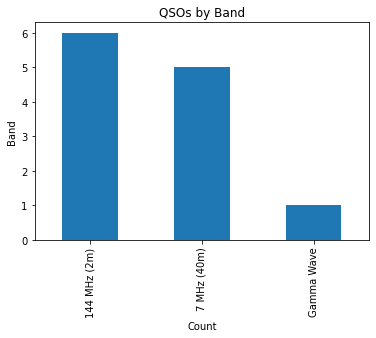

In [7]:
bandplot = df['Band'].value_counts().plot(kind = 'bar')
bandplot.set_title('QSOs by Band')
bandplot.set_xlabel('Count')
bandplot.set_ylabel('Band')

Text(0, 0.5, 'Mode')

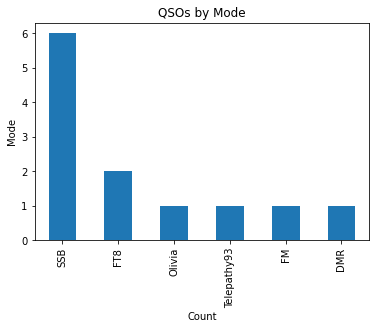

In [8]:
modeplot = df['Mode'].value_counts().plot(kind = 'bar')
modeplot.set_title('QSOs by Mode')
modeplot.set_xlabel('Count')
modeplot.set_ylabel('Mode')

Text(0, 0.5, 'Callsign')

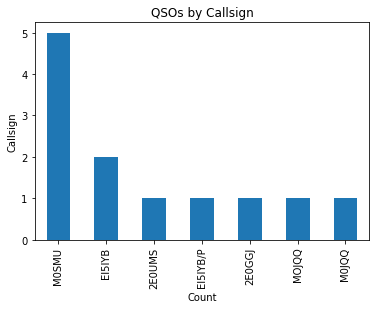

In [9]:
callplot = df['Your Callsign Clean'].value_counts().plot(kind = 'bar')
callplot.set_title('QSOs by Callsign')
callplot.set_xlabel('Count')
callplot.set_ylabel('Callsign')

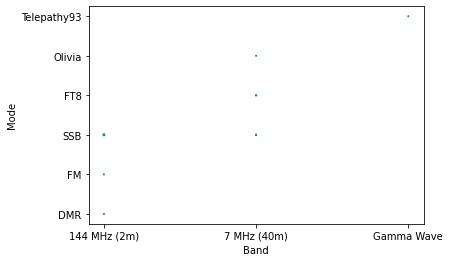

In [10]:
bandmodeplot = df.groupby(['Band','Mode']).size().reset_index(name='count').plot.scatter(x='Band', y='Mode', s='count')

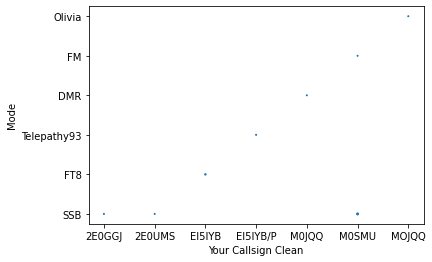

In [11]:
callsignmodeplot = df.groupby(['Your Callsign Clean','Mode']).size().reset_index(name='count').plot.scatter(x='Your Callsign Clean', y='Mode', s='count')

In [12]:
m = Map(
    basemap=basemap_to_tiles(basemaps.OpenStreetMap.Mapnik),
    center=(48.204, 350.121),
    zoom=3
    )
m

Map(center=[48.204, 350.121], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoo…